# Setting up the initial simulation grid


### Simulation parameters $H$

From each simulation we run, we will output a number of snapshots, of order 10. 

Moreover, for each snapshot we extract different sets of simulated Lyman-$\alpha$ skewers (normalized quasar spectra), after applying different rescalings of the temperatures in the snapshot. 
These skewers are written to disk.

Finally, from each set of skewers we measure different 1D power spectra, after rescaling the mean optical depth in the spectra. 
This optical depth rescaling is trivial, and it is done on the fly. 
Each of these measured power spectra is fed to the emulator. 


Let's discuss the parameterization of each of the simulation packages:

- As we discuss above, the emulator labels the measured power with the set of parameters $ M = \{ M_P, f, \lambda_F, \bar F, \sigma_T, \gamma \} $.

- Each set of simulated skewers, written to disk, is described by a subset of these $ \{ M_P, f, \lambda_F, \sigma_T, \gamma \} $, since we will have different values of $\bar F$ from the skewers.

- Each snapshot is described by an even smaller subset of parameters, $ \{ M_P, f, \lambda_F \} $, since we will reprocess the snapshot for different temperature-density relations.

If we assumed that we can do as much rescaling of mean flux and temperature as we wanted, then this last set of parameters $ \{ M_P, f, \lambda_F \} $ would be the only relevant ones. If we can not rescale as much as we would like to (because the rescaling breaks down at some point?), then we would need to label the snapshots with a "central temperature" and "central mean flux", around which we would perturb. 

Now, since we are describing the linear power in comoving units, the shape of the linear power will be the same in all snapshots. The only parameters that will vary are the amplitude of the linear power, the logarithmic growth rate $f$ and the filtering length $\lambda_F$. So each simulation will be described by two shape parameters, and $N_z \times \{ A_p, f, \lambda_F \}$, where $N_z$ is the number of snapshots. 

$$ H = \{ n_p, \alpha_p, N_z \times \{ A_p, f, \lambda_F \} \} $$


The question is: how do we decide what simulation to run, i.e., what configuration files to use, if we are handed a set of parameters $H$? We will not aim at having a perfect match between the two, we just want to get on the right ball park.

From the point of view of cosmological parameters:
 - We start by defining a fiducial cosmology, somewhere around Planck, but WITHOUT NEUTRINOS. This is important, since our simulations will not have neutrinos. All quantities with $^0$ will refer to that fiducial cosmology. 
 - In flat $\Lambda$CDM models, we can translate the requirement of a given $f_\star$ into a requirement of a given $\Omega_\star = \Omega_{cb}(z_\star)$, using $f_\star = \Omega_\star^{0.55}$.
 - We can then translate the requirement on $\Omega_\star$ to a requirement on $\Omega_{cb} = \Omega_{cb}(z=0)$, using $\Omega_\star = \Omega_{cb} (1+z_\star)^3 / ( \Omega_{cb} (1+z_\star)^3 + 1 - \Omega_{cb} ) $. 
 - We will keep fixed the values of $\Omega_c h^2$ and $\Omega_b h^2$, so the requirement on $\Omega_{cb}$ can be related to a requirement on $h$, using $h^2 = (\Omega_b h^2 + \Omega_c h^2)/\Omega_{cb} $.
 - We will also measure the shape of the linear power at $z_\star$ around $k_p$, and modify the slope and running of the primordial power to match the required shape.
 - So the cosmology in the simulation will be specified by $\{ \Omega_\star, A_p, n_p, \alpha_p \}$, where $A_p$ will be computed at $z_\star$.

From the point of view of the pressure smoothing:
 - We will look at the value of the filtering length at a pre-HeII and at a post-HeII redshift, say z=2 and z=4. 
 - We will use the Oñorbe models to translate the required values for $\lambda_F$ pre- and post-HeII reionization to a required thermal history. It will probably be enough to specify a scaling of the heating rates before ($\mu_H$) and after ($\mu_{He}$) He_II reionizaion. 

### Initial simulation grid

We have 6 simulation parameters: 

$$ H = \{ \mu_H, \mu_{He}, \Omega_\star, \Delta_p^2, n_p, \alpha_p \} $$

We will choose the following parameter volume for the simulations:
 - $ 0.5 < \mu_H < 2.0 $
 - $ 0.5 < \mu_{He} < 2.0 $
 - $ 0.950 < \Omega_\star < 0.975 $
 - $ 0.25 < \Delta_p^2 < 0.45 $
 - $ -2.4 < n_p < -2.3 $
 - $ -0.12 < \alpha_p < -0.08 $

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import copy
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import fit_pk
import read_genic
import write_config
import camb_cosmo
import latin_hypercube

In [2]:
def get_sim_params(z_star=3.0,kp_Mpc=0.7,add_running=False,add_mu_H=False):
    """Return list of simulation parameters, with name and allowed range"""
    params={}
    params['Om_star']={'ip':len(params), 'min_val':0.950, 'max_val':0.975, 'z_star':z_star, 'latex':r'$\Omega_\star$'}
    params['Delta2_star']={'ip':len(params), 'min_val':0.25, 'max_val':0.45, 'z_star':z_star, 'kp_Mpc':kp_Mpc, 'latex':r'$\Delta^2_\star$'}
    params['n_star']={'ip':len(params), 'min_val':-2.35, 'max_val':-2.25, 'z_star':z_star, 'kp_Mpc':kp_Mpc, 'latex':r'$n_\star$'}
    if add_running:
        params['alpha_star']={'ip':len(params), 'min_val':-0.1175, 'max_val':-0.0975, 'z_star':z_star, 'kp_Mpc':kp_Mpc, 'latex':r'$\alpha_\star$'}
    params['mu_He']={'ip':len(params), 'min_val':0.5, 'max_val':2.0, 'latex':r'$\mu_{\rm He}$'}
    if add_mu_H:
        params['mu_H']={'ip':len(params), 'min_val':0.5, 'max_val':2.0, 'latex':r'$\mu_{\rm H}$'}
    return params

- Setup Latin hypercube

In [3]:
# get list of simulation parameters
z_star=3.0
kp_Mpc=0.7
add_running=True
param_space = get_sim_params(z_star=z_star,kp_Mpc=kp_Mpc,add_running=add_running)
Npar=len(param_space)
param_limits=np.empty([Npar,2])
for key,param in param_space.items():
    ip=param['ip']
    #print("{} = {}".format(key, ip))
    param_limits[ip][0]=param['min_val']
    param_limits[ip][1]=param['max_val']

In [4]:
# generate Latin hypercube 
nsamples=6
seed=101
cube=latin_hypercube.get_hypercube_samples(param_limits, nsamples, prior_points = None, seed=seed)

 - Setup fiducial cosmology

In [5]:
cosmo_fid = camb_cosmo.get_cosmology()
camb_cosmo.print_info(cosmo_fid)
# get linear power parameters, in comoving units
linP_params_fid=fit_pk.parameterize_cosmology_Mpc(cosmo_fid,z_star=z_star,kp_Mpc=kp_Mpc)
print('fiducial linear power parameters',linP_params_fid)

H0 = 67.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.965 ; alpha_s = 0.0
fiducial linear power parameters {'f_star': 0.98136945578065649, 'g_star': 0.9677508579459803, 'linP_Mpc': poly1d([-0.10748531, -2.30256519,  3.04180742])}


 - For each point in cube, write configuration files to run simulation

In [6]:
sim_dirs='test_cube/'
write_config.mkdir_if_not_exists(sim_dirs)
write_config.write_cube_json_file(sim_dirs+'latin_hypercube',param_space)
info_cosmologies=[]
for sample in range(nsamples):
    sim_params=cube[sample]
    print(sample,sim_params)
    cosmo_sim=fit_pk.cosmo_from_sim_params(param_space,sim_params,cosmo_fid,linP_params_fid,z_star,kp_Mpc,verbose=False)
    sim_dir=sim_dirs+'sim_'+str(sample)+'/'
    write_config.mkdir_if_not_exists(sim_dir)
    file_name=sim_dir+'paramfile'
    # write GenIC and MP-Gadget parameters, for both simulations in pair
    for paired in [False,True]:
        write_config.write_genic_file(file_name,cosmo_sim,paired=paired)
        write_config.write_gadget_file(file_name,cosmo_sim,paired=paired)
    # compute fit parameters and store in JSON format
    linP_params_sim=fit_pk.parameterize_cosmology_Mpc(cosmo_sim,z_star=z_star,kp_Mpc=kp_Mpc)  
    write_config.write_sim_json_file(file_name,param_space,sim_params,linP_params_sim)
    # store information for plots
    info_cosmo={'cosmo':cosmo_sim,'sim_params':sim_params,'linP_params':linP_params_sim}
    info_cosmologies.append(info_cosmo)

0 [ 0.96875     0.4        -2.30833333 -0.10916667  1.375     ]
Modify GenIC to allow for running -0.0016871248217996682
Modify GenIC to allow for running -0.0016871248217996682
1 [ 0.95625     0.33333333 -2.275      -0.10583333  0.875     ]
Modify GenIC to allow for running 0.0016573105097995033
Modify GenIC to allow for running 0.0016573105097995033
2 [ 0.96041667  0.3        -2.25833333 -0.1125      1.625     ]
Modify GenIC to allow for running -0.005011356799012573
Modify GenIC to allow for running -0.005011356799012573
3 [ 0.96458333  0.36666667 -2.325      -0.1025      1.125     ]
Modify GenIC to allow for running 0.004985840166349925
Modify GenIC to allow for running 0.004985840166349925
4 [ 0.97291667  0.26666667 -2.29166667 -0.09916667  1.875     ]
Modify GenIC to allow for running 0.00831624946392158
Modify GenIC to allow for running 0.00831624946392158
5 [ 0.95208333  0.43333333 -2.34166667 -0.11583333  0.625     ]
Modify GenIC to allow for running -0.008341912891640352
Modi

In [7]:
print(info_cosmologies[0]['linP_params'])
print('sim_params',info_cosmologies[0]['sim_params'])

{'f_star': 0.98215486226976045, 'g_star': 0.9691665714833316, 'linP_Mpc': poly1d([-0.1083231 , -2.30833333,  3.13634105])}
sim_params [ 0.96875     0.4        -2.30833333 -0.10916667  1.375     ]


In [8]:
labels=['']*Npar
for key,param in param_space.items():
    ip=param['ip']
    labels[ip]=param['latex']

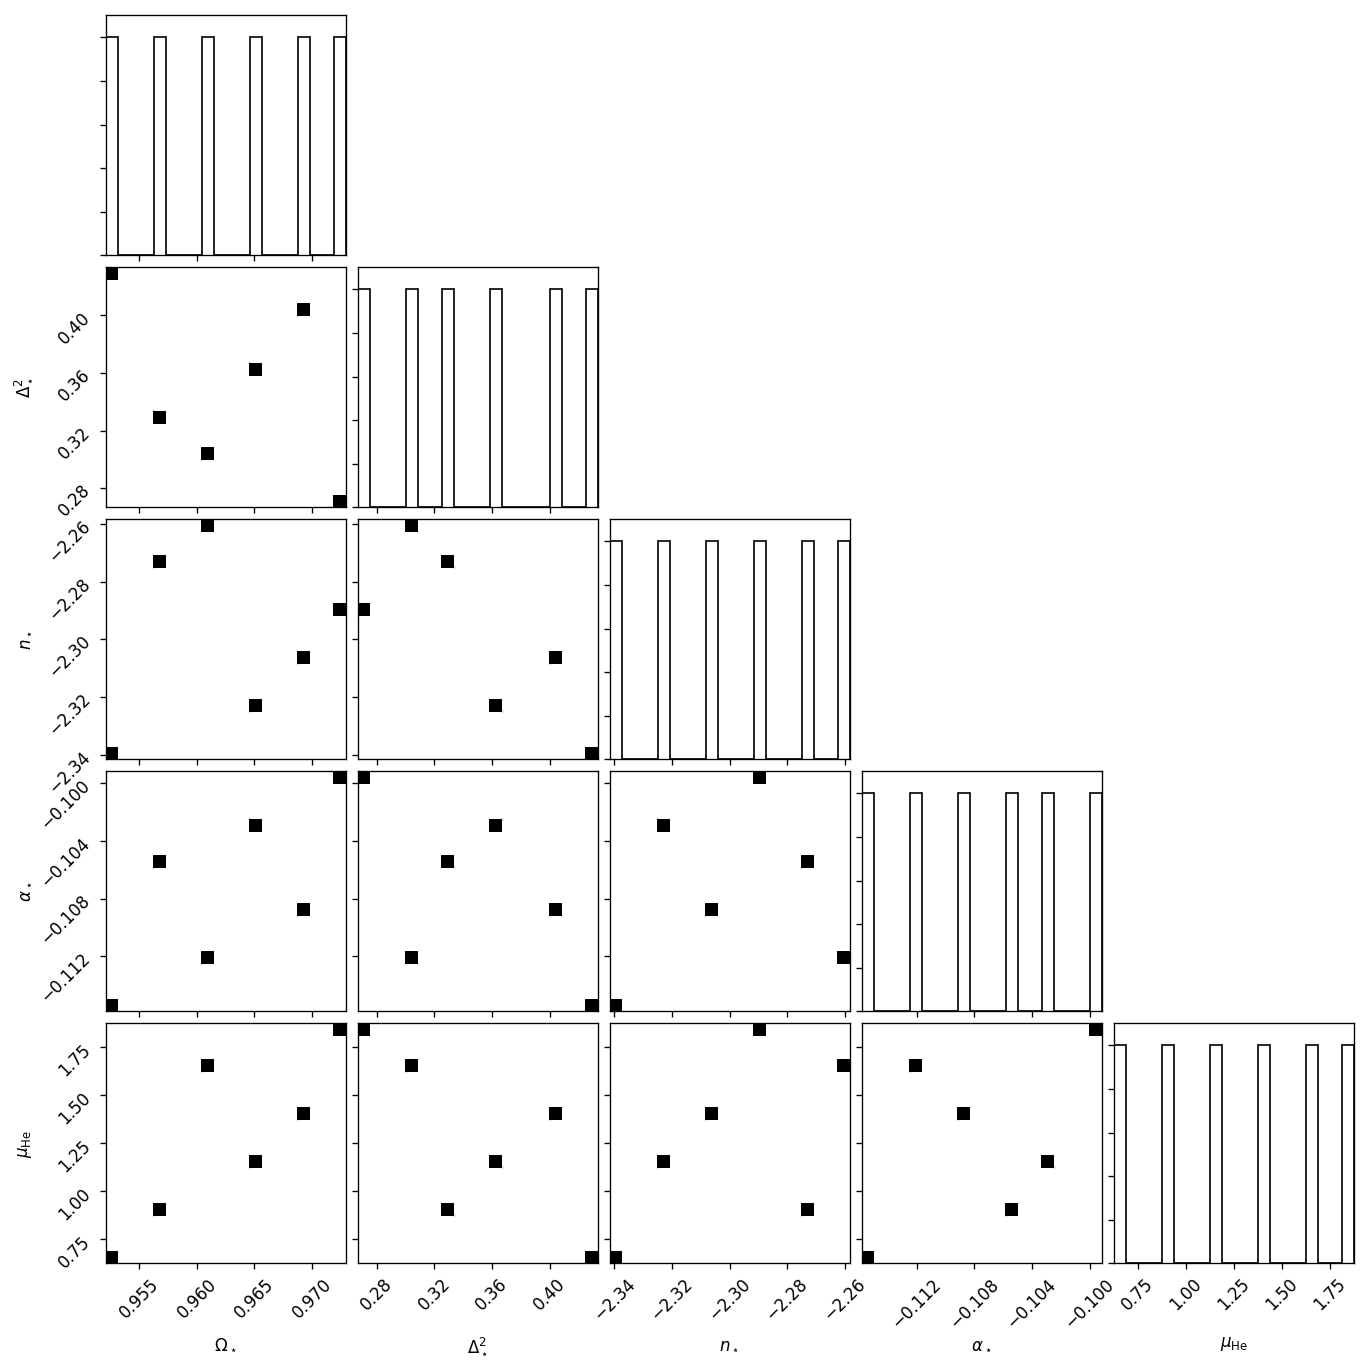

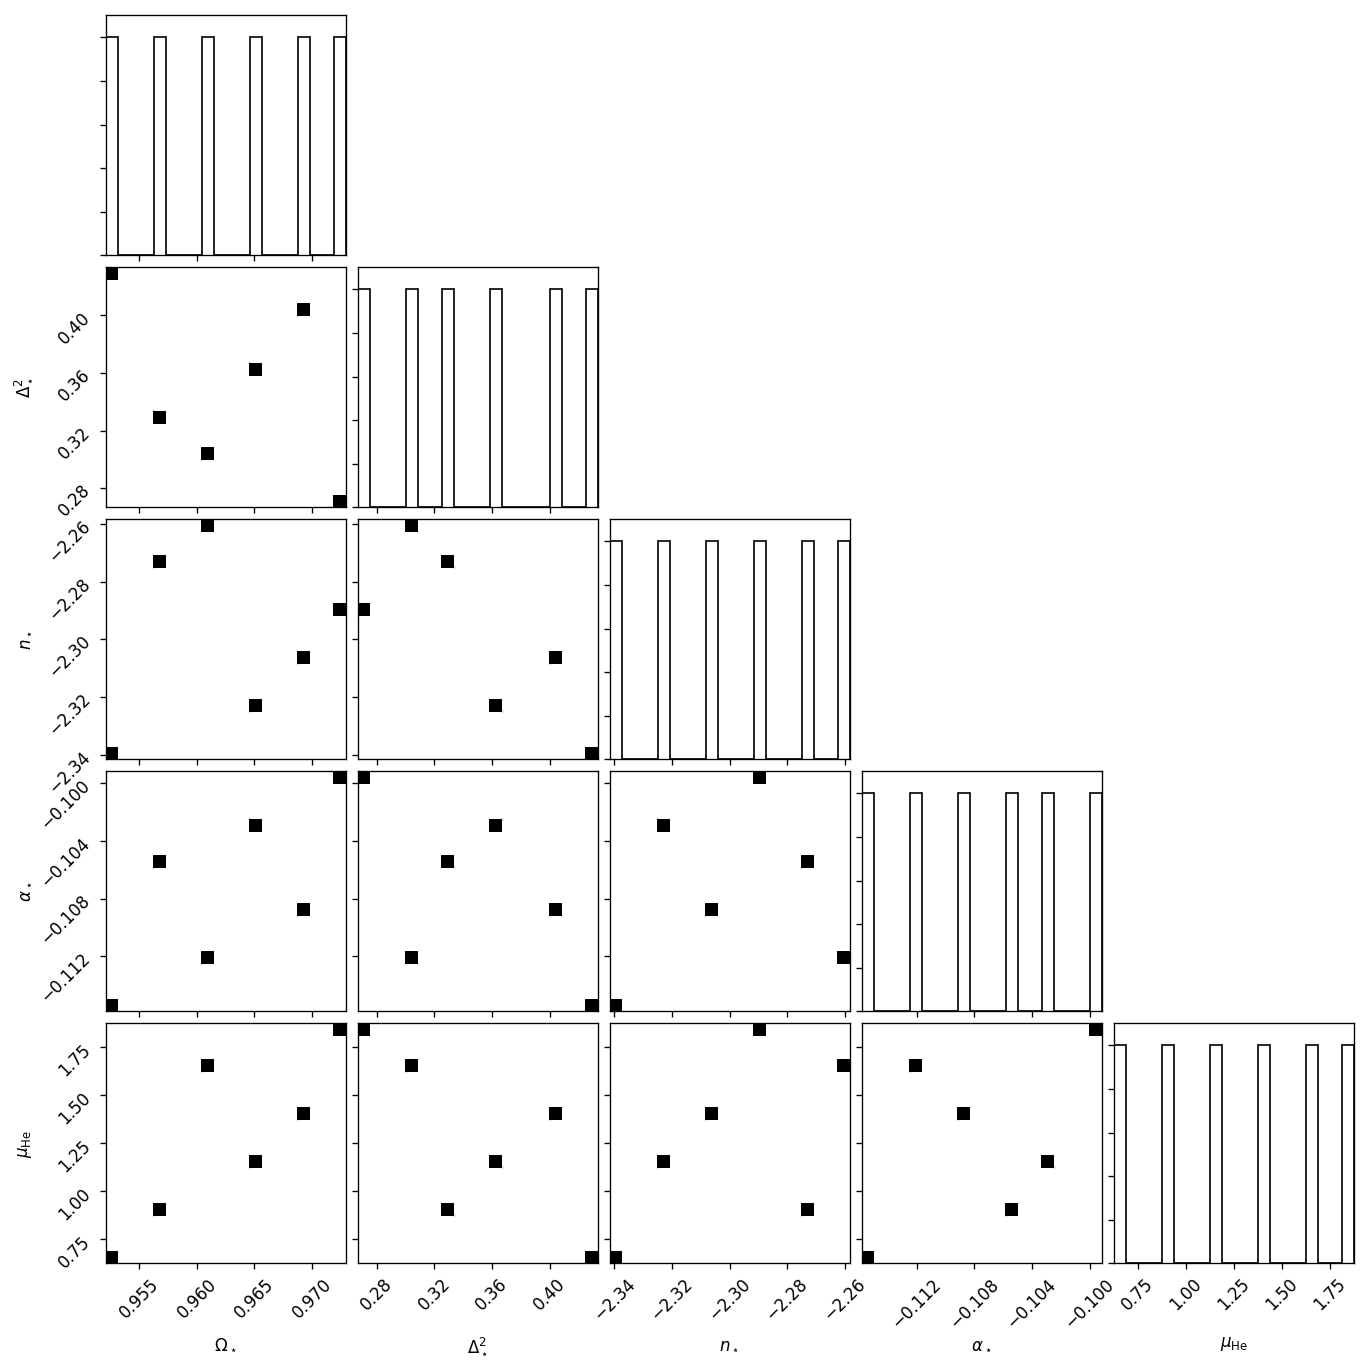

In [9]:
import corner
corner.corner(cube,labels=labels)

In [10]:
# plot corner plot for derived parameters
if add_running:
    labels=[r'$H_0$',r'$\Omega_m$',r'$A_s$',r'$n_s$',r'$\alpha_s$']
else:
    labels=[r'$H_0$',r'$\Omega_m$',r'$A_s$',r'$n_s$']
Npar=len(labels)
Ncos=len(info_cosmologies)
print(labels)
derived_params=np.ndarray([Ncos,Npar])
print(derived_params.shape)
for icosmo in range(Ncos):
    cosmo = info_cosmologies[icosmo]['cosmo']
    H0=cosmo.H0
    h=H0/100.0
    omh2=cosmo.omch2+cosmo.ombh2
    derived_params[icosmo][0]=H0
    derived_params[icosmo][1]=(omh2/h**2)
    derived_params[icosmo][2]=cosmo.InitPower.As
    derived_params[icosmo][3]=cosmo.InitPower.ns
    if add_running:
        derived_params[icosmo][4]=cosmo.InitPower.nrun

['$H_0$', '$\\Omega_m$', '$A_s$', '$n_s$', '$\\alpha_s$']
(6, 5)


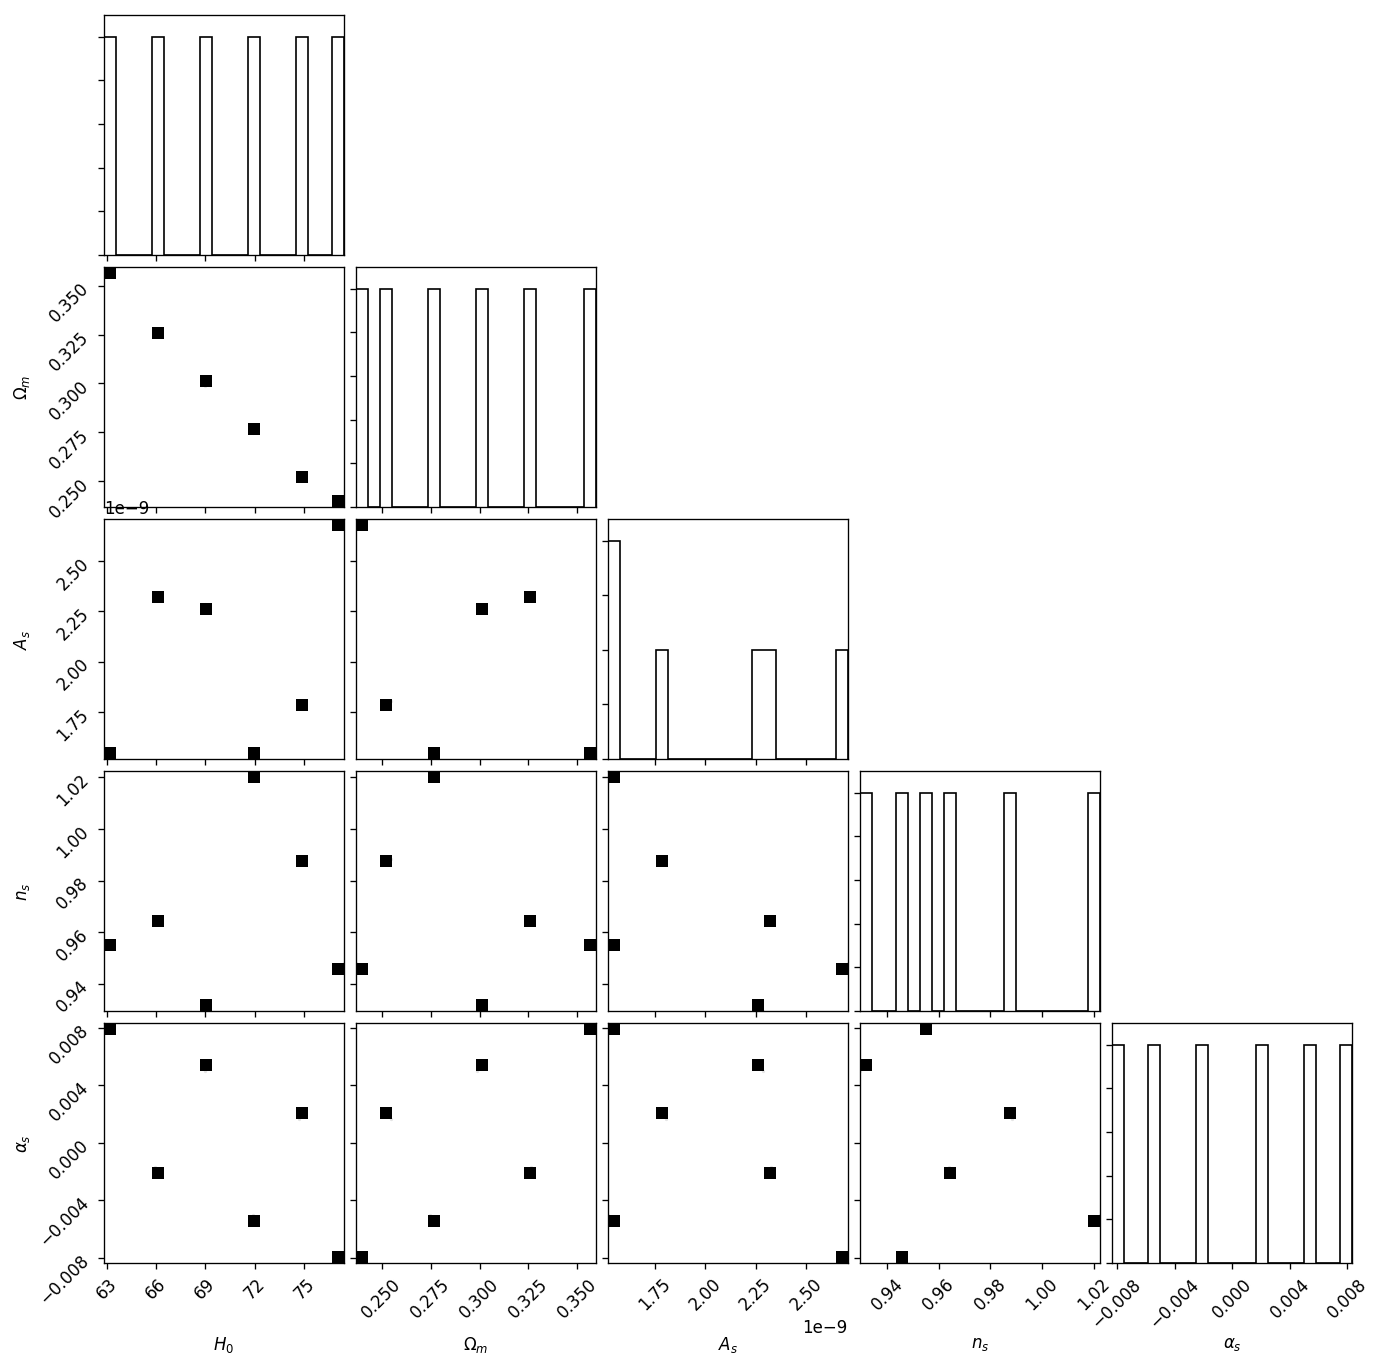

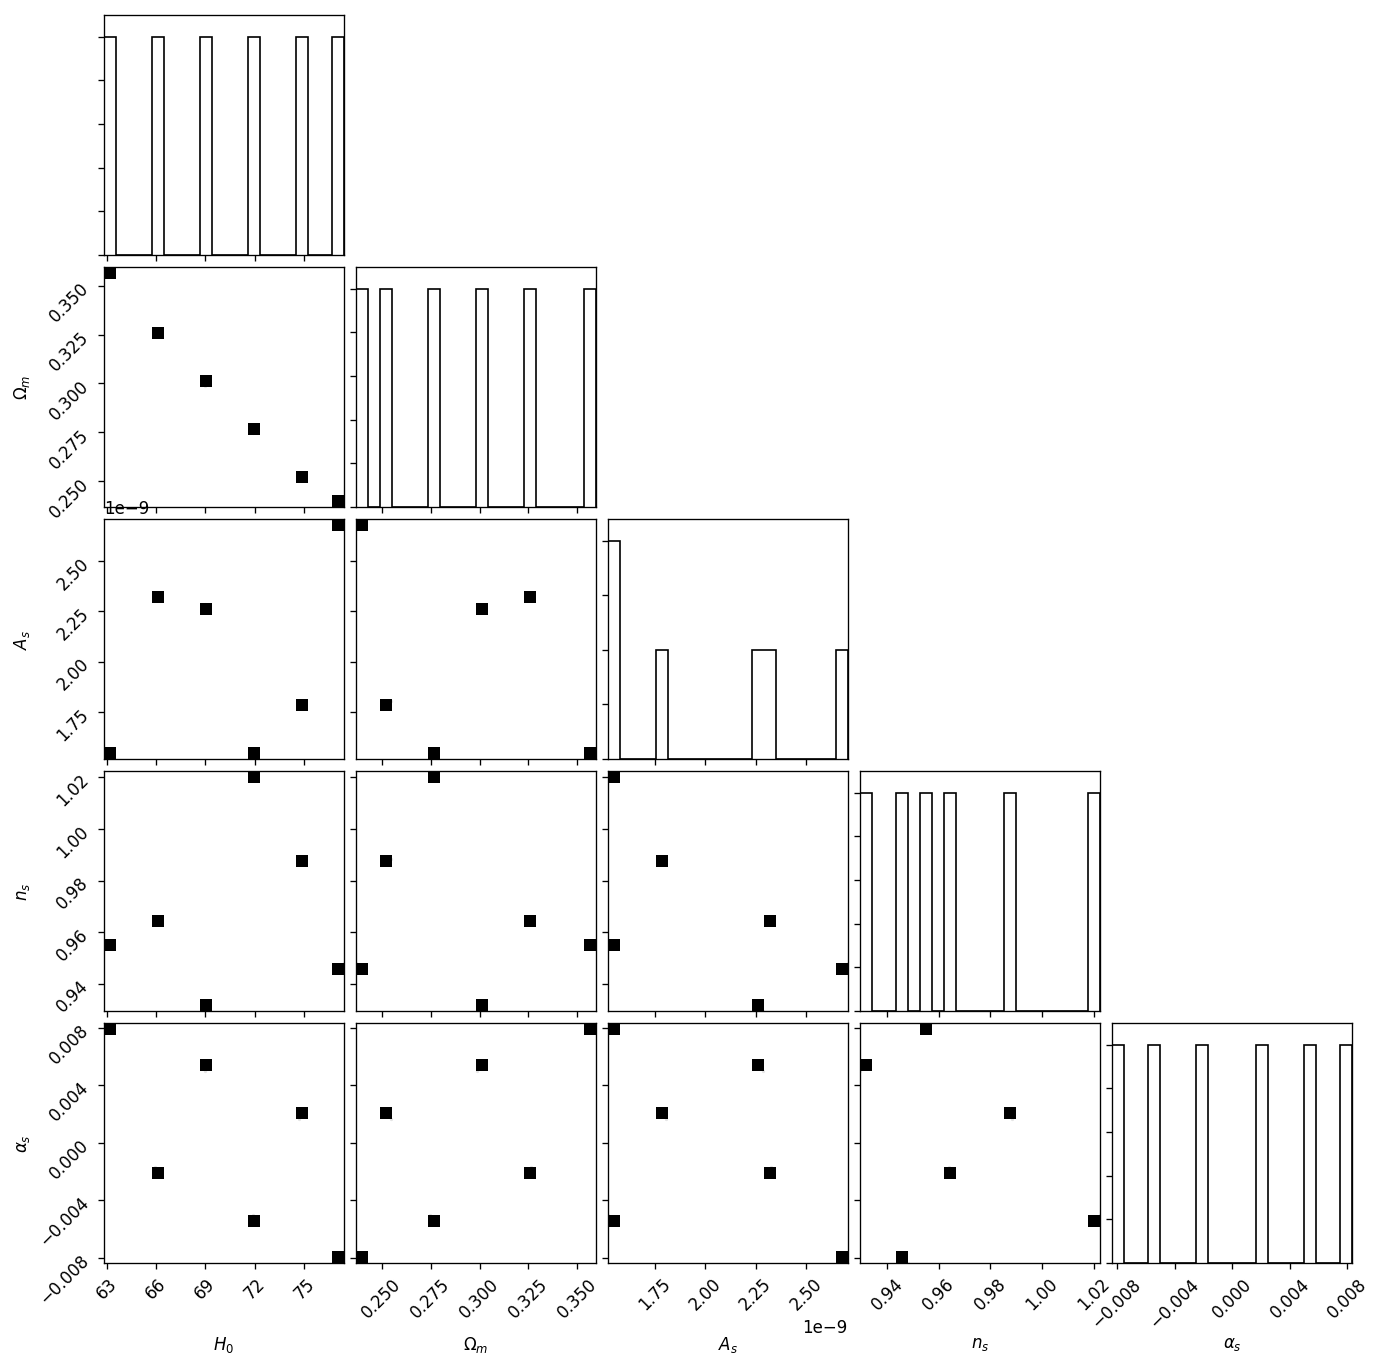

In [11]:
corner.corner(derived_params,labels=labels)